# Water Potability

### 1. Import libraries needed

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import keras

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

### 2. Load data

In [2]:
df = pd.read_csv("water_potability.csv", header=0, index_col=False)
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


### 3. Preprocess Data

In [3]:
df = df.dropna(how="any")
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
3269,11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


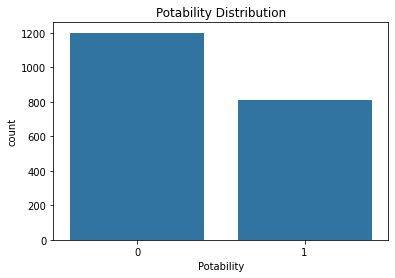

In [5]:
plt.figure()
plt.title("Potability Distribution")
sns.countplot(data=df, x=df["Potability"])

plt.show()

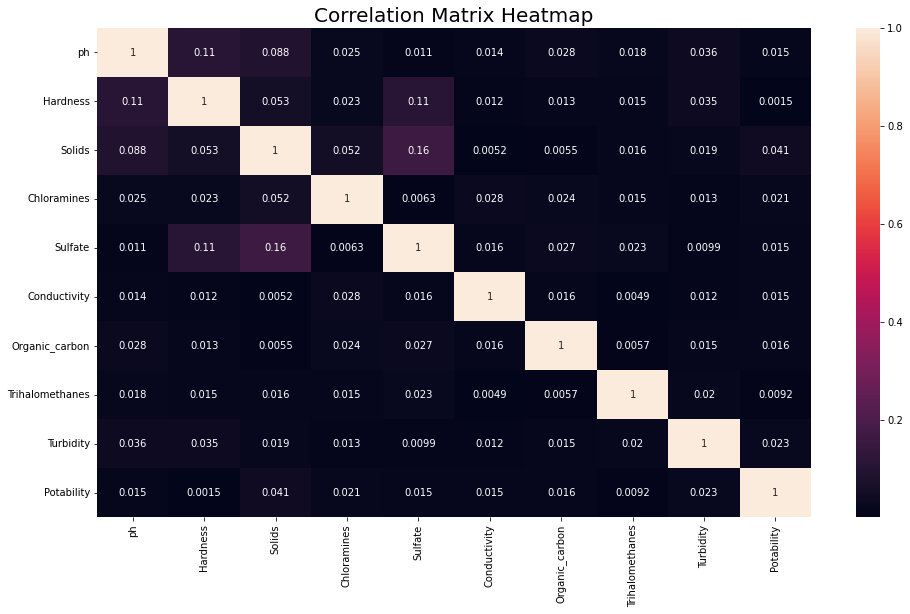

In [6]:
# See correlation
plt.figure(figsize=(16, 9))
sns.heatmap(abs(df.corr()), cbar=True, annot=True)
plt.title("Correlation Matrix Heatmap", fontdict={"size": 20})
plt.xticks()
plt.yticks()
plt.show()

In [7]:
corr_df = abs(df.corr())
corr_df
strong_relation_features = pd.Series(corr_df["Potability"]).nlargest(n=8).iloc[1:]
strong_relation_features

Solids            0.040674
Turbidity         0.022682
Chloramines       0.020784
Organic_carbon    0.015567
Conductivity      0.015496
Sulfate           0.015303
ph                0.014530
Name: Potability, dtype: float64

### 4. Drop Outliers

In [8]:
def check_outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Menghitung RUB dan RLB.
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = (df < lower_limit) | (df > upper_limit)
    return outliers

In [9]:
data_clean = df[
    [
        "Solids",
        "Turbidity",
        "Chloramines",
        "Organic_carbon",
        "Sulfate",
        "ph",
        "Potability",
    ]
]

outliers = dict(check_outlier(data_clean).sum())

for col in outliers:
    print(f"Number of outliers in attribute {col}: {outliers[col]}")
    print(f"Percentage of number of outliers: {100*outliers[col]/len(data_clean):.2f}%")
    print()

Number of outliers in attribute Solids: 28
Percentage of number of outliers: 1.39%

Number of outliers in attribute Turbidity: 11
Percentage of number of outliers: 0.55%

Number of outliers in attribute Chloramines: 43
Percentage of number of outliers: 2.14%

Number of outliers in attribute Organic_carbon: 14
Percentage of number of outliers: 0.70%

Number of outliers in attribute Sulfate: 37
Percentage of number of outliers: 1.84%

Number of outliers in attribute ph: 31
Percentage of number of outliers: 1.54%

Number of outliers in attribute Potability: 0
Percentage of number of outliers: 0.00%



In [10]:
outliers_checked = check_outlier(data_clean)

outliers_indices = outliers_checked.any(axis=1)
data_clean = data_clean[~outliers_indices]

data_clean

,Solids,Turbidity,Chloramines,Organic_carbon,Sulfate,ph,Potability
3,22018.417441,4.628771,8.059332,18.436524,356.886136,8.316766,0
4,17978.986339,4.075075,6.546600,11.558279,310.135738,9.092223,0
5,28748.687739,2.559708,7.544869,8.399735,326.678363,5.584087,0
6,28749.716544,2.672989,7.513408,13.789695,393.663396,10.223862,0
7,13672.091764,4.401425,4.563009,12.363817,303.309771,8.635849,0
...,...,...,...,...,...,...,...
3264,20526.666156,4.390702,6.349561,18.963707,341.256362,5.893103,1
3265,27701.794055,3.361833,6.472914,14.250875,328.886838,8.197353,1
3267,15921.412018,4.613843,6.297312,9.899115,312.931022,8.989900,1
3268,17246.920347,3.442983,7.708117,16.217303,304.510230,6.702547,1


### 4. Split inputs and labels

In [11]:
X = data_clean[
    ["Solids", "Turbidity", "Chloramines", "Organic_carbon", "Sulfate", "ph"]
]
y = data_clean["Potability"]
X

,Solids,Turbidity,Chloramines,Organic_carbon,Sulfate,ph
3,22018.417441,4.628771,8.059332,18.436524,356.886136,8.316766
4,17978.986339,4.075075,6.546600,11.558279,310.135738,9.092223
5,28748.687739,2.559708,7.544869,8.399735,326.678363,5.584087
6,28749.716544,2.672989,7.513408,13.789695,393.663396,10.223862
7,13672.091764,4.401425,4.563009,12.363817,303.309771,8.635849
...,...,...,...,...,...,...
3264,20526.666156,4.390702,6.349561,18.963707,341.256362,5.893103
3265,27701.794055,3.361833,6.472914,14.250875,328.886838,8.197353
3267,15921.412018,4.613843,6.297312,9.899115,312.931022,8.989900
3268,17246.920347,3.442983,7.708117,16.217303,304.510230,6.702547


### 5. Split data to training and testing

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [51]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train_scaled = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test_scaled = X_test2

### 6. Arsitektur model

In [58]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=32, input_shape=(6,), activation="relu"),
        tf.keras.layers.Dense(units=256, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.8)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 32
history = model.fit(
    X_train_scaled,
    y_train,
    batch_size=batch_size,
    steps_per_epoch=len(X_train) / batch_size,
    epochs=100,
    validation_data=(X_test_scaled, y_test),
)

Epoch 1/100
46/46 [==============================] - 1s 6ms/step - loss: 0.6788 - accuracy: 0.5914 - val_loss: 0.6689 - val_accuracy: 0.6005
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.6062 - val_loss: 0.6639 - val_accuracy: 0.6005
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6597 - accuracy: 0.6062 - val_loss: 0.6609 - val_accuracy: 0.6005
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6544 - accuracy: 0.6062 - val_loss: 0.6586 - val_accuracy: 0.6032
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.6149 - val_loss: 0.6565 - val_accuracy: 0.6166
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6453 - accuracy: 0.6223 - val_loss: 0.6548 - val_accuracy: 0.6139
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.6358 - val_loss: 0.6525 - val_accuracy: 0.6113
Epoch 8/100
4

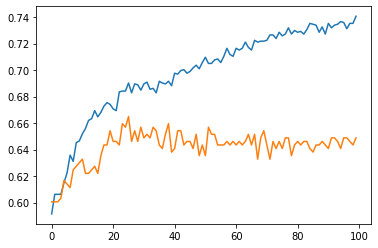

In [59]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

### 7. Testing

In [60]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy*100}%")

12/12 [==============================] - 0s 1ms/step - loss: 2883.1475 - accuracy: 0.6005
Test loss: 2883.1474609375
Test accuracy: 60.053616762161255%


In [61]:
prediction = model.predict(X_test)
predicted_label = (prediction > 0.5).astype(int)

12/12 [==============================] - 0s 1ms/step


In [62]:
print(X_test.tail())
print(f"Predicted: {predicted_label[-5:]}")
print(f"Ground truth: {y_test.tail()}")

            Solids  Turbidity  Chloramines  Organic_carbon     Sulfate  \
727   15157.268787   4.427712     7.582124       14.221757  307.704474   
459    7013.211787   4.192932     8.451601       17.929395  355.213897   
308   15300.838671   5.163088     7.486598       19.600429  316.956934   
2686  16769.890546   3.585431     4.745340       14.189856  292.419247   
419   22229.230090   3.902838     9.922078       12.001547  295.131831   

            ph  
727   6.017261  
459   8.639541  
308   6.795469  
2686  7.945909  
419   4.961353  
Predicted: [[0]
 [0]
 [0]
 [0]
 [0]]
Ground truth: 727     1
459     0
308     1
2686    0
419     0
Name: Potability, dtype: int64


Text(91.68, 0.5, 'predicted class')

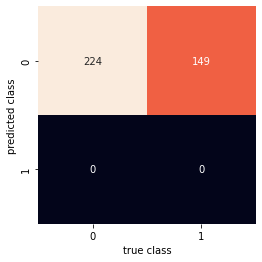

In [63]:
conmat = confusion_matrix(y_test, predicted_label)
sns.heatmap(conmat.T, square=True, annot=True, fmt="d", cbar=False)
plt.xlabel("true class")
plt.ylabel("predicted class")

### 8. Save model

In [64]:
model.save("17-6-potability-iot.h5")

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
model = tf.keras.models.load_model("17-6-potability-iot.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("17-6-potability-iot.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmps47zycc6\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmps47zycc6\assets


In [ ]:
from tflite_support import metadata as _metadata

model_path = "17-6-potability-iot.tflite"
displayer = _metadata.MetadataDisplayer.with_model_file(model_path)
export_json_file = "17-6-extracted_metadata.json"
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)